
# 🥊📊 UFC Data Analysis — Winner vs Loser (Portfolio Edition)

**Goal:** Identify which fight stats correlate with winning.

**Scope:** Modern UFC fights (dataset ends at 30 Aug; update instructions included).

**Why these stats?**
- **Significant Strikes** and **Knockdowns** capture striking dominance.
- **Takedowns** and **Submission Attempts** capture grappling control and finishing pressure.

> This notebook is structured for clarity and hiring-manager readability: short, purposeful sections, reproducible code, and takeaways after each visual.


### Setup

In [0]:
import re

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Display options
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

# Plot theme
sns.set_theme(style="whitegrid")


### Load Data

In [2]:
event_df = pd.read_csv("ufc_data/ufc_event_data.csv")
fighter_df = pd.read_csv("ufc_data/ufc_fighters.csv")

display(event_df.head())
display(fighter_df.head())


FileNotFoundError: [Errno 2] No such file or directory: 'ufc_data/ufc_event_data.csv'

### Cleaning & Standardization

In [ ]:

# --- Fighter table cleanup
fighter_df = fighter_df.copy()
if set(["First Name","Last Name"]).issubset(fighter_df.columns):
    fighter_df["Name"] = fighter_df["First Name"].str.strip() + " " + fighter_df["Last Name"].str.strip()
    fighter_df = fighter_df.drop(columns=[c for c in ["Nickname","First Name","Last Name"] if c in fighter_df.columns])

# --- Event table cleanup
event_df = event_df.copy()

# Dates to datetime
if "Event Date" in event_df.columns:
  event_df["Event Date"] = pd.to_datetime(event_df["Event Date"], errors="coerce")

# Column renaming for clarity (use what's present)
renaming = {
  "Fighter1": "Winner",
  "Fighter2": "Loser",
  "KD": "Knockdowns",
  "Sig. str.": "Significant Strikes",
  "Td": "Takedowns",
  "Sub. att": "Submission Attempts",
}
event_df = event_df.rename(columns={k:v for k,v in renaming.items() if k in event_df.columns})

# Derive Winner/Loser columns from paired string fields when needed
# Many scrapes store stats like '50-20' (winner-loser). Parse into two numeric columns.
def _split_pair(series):
  s = series.astype(str)
  # Extract integers around a hyphen, tolerating spaces
  out = s.str.extract(r"\s*(\d+)\s*-\s*(\d+)\s*")
  out = out.rename(columns={0: 'win', 1: 'loss'})
  out['win'] = pd.to_numeric(out['win'], errors='coerce')
  out['loss'] = pd.to_numeric(out['loss'], errors='coerce')
  return out

# Map raw aggregated columns to canonical Winner/Loser targets
pair_sources = [
    ('Strikes', 'Sig Strikes'),
    ('TD', 'Takedowns Landed'),
    ('Sub', 'Submission Attempts'),
    ('Knockdowns', 'Knockdowns'),  # may have been renamed from 'KD' above
]
for src, label in pair_sources:
  if src in event_df.columns:
    parsed = _split_pair(event_df[src])
    event_df[f'Winner {label}'] = parsed['win']
    event_df[f'Loser {label}']  = parsed['loss']

# Winner/Loser stat columns (for side-by-side comparison)
# Expect columns like "Winner Sig Strikes", "Loser Sig Strikes" etc.
candidate_pairs = [
  ("Winner Sig Strikes", "Loser Sig Strikes"),
  ("Winner Takedowns Landed", "Loser Takedowns Landed"),
  ("Winner Submission Attempts", "Loser Submission Attempts"),
  ("Winner Knockdowns", "Loser Knockdowns"),
]
present_pairs = [(win,loss) for (win,loss) in candidate_pairs if win in event_df.columns and loss in event_df.columns]

# Basic NA handling
na_report = event_df.isna().sum().sort_values(ascending=False)
display(pd.DataFrame({"missing": na_report[na_report>0]}))

# Simple imputation for numeric analytical columns (median)
for win, loss in present_pairs:
  for c in (win, loss):
    if event_df[c].isna().any():
      event_df[c] = event_df[c].fillna(event_df[c].median())


,missing


### Descriptive Statistics

In [ ]:

desc = event_df.select_dtypes(include="number").describe().T
display(desc.head(12))


,count,mean,std,min,25%,50%,75%,max
Round,2863.0,2.462801,1.035328,1.0,2.0,3.0,3.0,5.0
Winner Sig Strikes,2863.0,53.330073,39.557984,0.0,23.0,45.0,76.0,445.0
Loser Sig Strikes,2863.0,37.409710,31.944442,0.0,12.0,31.0,55.0,271.0
Winner Takedowns Landed,2863.0,1.417045,2.020168,0.0,0.0,1.0,2.0,14.0
Loser Takedowns Landed,2863.0,0.658750,1.198590,0.0,0.0,0.0,1.0,9.0
Winner Submission Attempts,2863.0,0.427873,0.814967,0.0,0.0,0.0,1.0,7.0
Loser Submission Attempts,2863.0,0.155781,0.502447,0.0,0.0,0.0,0.0,5.0
Winner Knockdowns,2863.0,0.364303,0.606577,0.0,0.0,0.0,1.0,6.0
Loser Knockdowns,2863.0,0.054838,0.243999,0.0,0.0,0.0,0.0,2.0


### Winner vs Loser — Mean Comparison (4 stats)

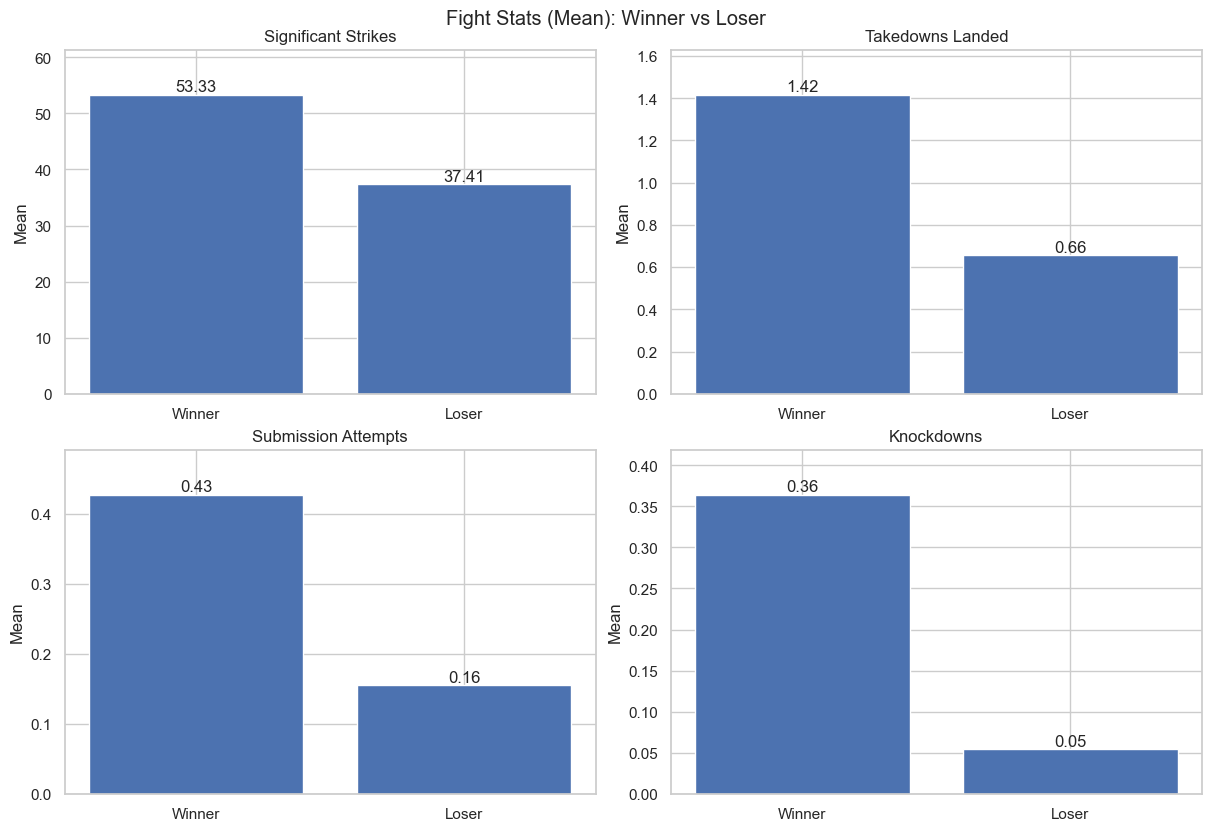

In [ ]:

order = ["Significant Strikes", "Takedowns Landed", "Submission Attempts", "Knockdowns"]
# Backward compatibility with slightly different column names
canonical_map = {
  "Significant Strikes": ("Winner Sig Strikes","Loser Sig Strikes"),
  "Takedowns Landed": ("Winner Takedowns Landed","Loser Takedowns Landed"),
  "Submission Attempts": ("Winner Submission Attempts","Loser Submission Attempts"),
  "Knockdowns": ("Winner Knockdowns","Loser Knockdowns"),
}
available = [s for s in order if set(canonical_map[s]).issubset(event_df.columns)]

n = len(available)
rows, cols = 2, 2
fig, axes = plt.subplots(rows, cols, figsize=(12, 8), constrained_layout=True)
axes = axes.ravel()

for ax, stat in zip(axes, available):
  wcol, lcol = canonical_map[stat]
  means = [event_df[wcol].mean(), event_df[lcol].mean()]
  bars = ax.bar(["Winner","Loser"], means)
  ax.set_title(stat)
  ax.set_ylabel("Mean")

  # y-limit padding
  ymax = max(means) if len(means) else 1.0
  ax.set_ylim(0, ymax * 1.15 if ymax > 0 else 1)

  # annotate bars
  for idx, val in enumerate(means):
    ax.text(idx, val, f"{val:.2f}", ha="center", va="bottom")

# remove any unused axes if fewer than 4 stats are available
for j in range(len(available), rows*cols):
  fig.delaxes(axes[j])

plt.suptitle("Fight Stats (Mean): Winner vs Loser", y=1.02)
plt.show()



**Takeaway:** Winners typically lead in striking and/or grappling pressure; the annotated values make the magnitude of differences obvious at a glance.


###  How Did the Fights End?

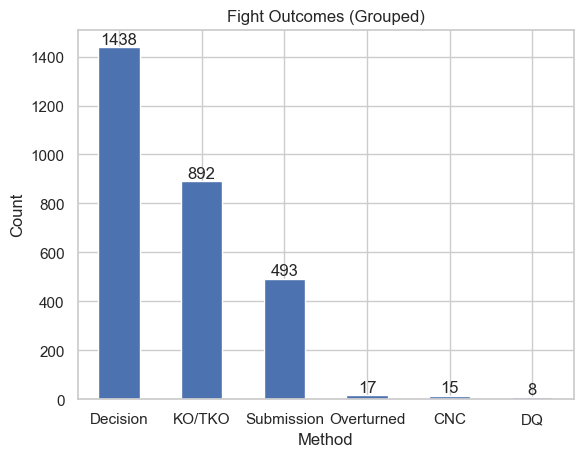

,count,pct
Method,,
Decision,1438,0.502
KO/TKO,892,0.312
Submission,493,0.172
Overturned,17,0.006
CNC,15,0.005
DQ,8,0.003


In [ ]:

# Create a normalized 'Method (grouped)' label
method_col = None
for c in ["Method","Fight Ended","Ending Method"]:
  if c in event_df.columns:
    method_col = c
    break

if method_col is None:
  raise ValueError("Could not find a column that indicates fight method (e.g., 'Method').")

method_map = {
  r".*KO/TKO.*": "KO/TKO",
  r".*SUB.*": "Submission",
  r".*Overturned.*": "Overturned",
  r".*DEC.*": "Decision",
}
method_grouped = event_df[method_col].astype(str).replace(method_map, regex=True)
vc = method_grouped.value_counts(dropna=False).sort_values(ascending=False)

ax = vc.plot(kind="bar")
ax.set_title("Fight Outcomes (Grouped)")
ax.set_ylabel("Count")
for i, v in enumerate(vc.values):
  ax.text(i, v, str(v), ha="center", va="bottom")
plt.xticks(rotation=0)
plt.show()

vc.to_frame("count").assign(pct=lambda d: d["count"].div(d["count"].sum()).round(3)).head(10)



**Takeaway:** Mos fights finish via a decision; KO/TKO and Submissions form the bulk of finishes. This baseline informs which skills tend to be decisive.


### Submission Breakdown

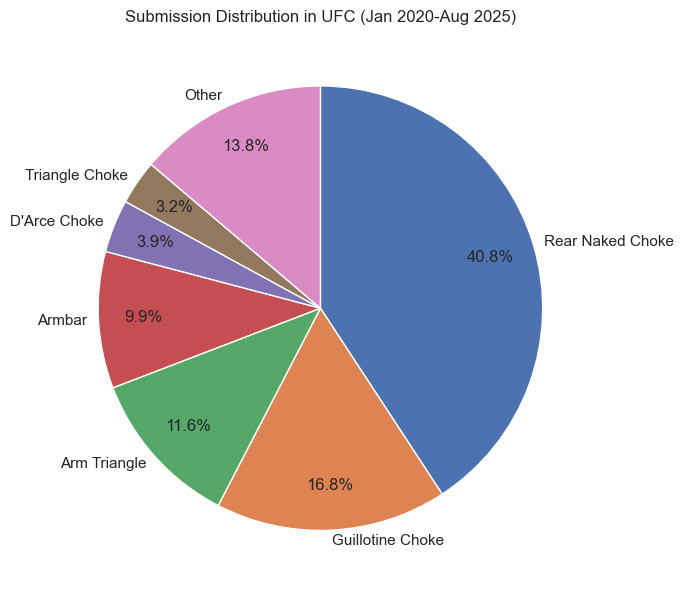

In [ ]:
s = pd.read_csv("ufc_data/ufc_event_data.csv")["Method"]

subs = s[s.str.contains("SUB", na=False)]

# Clean labels → e.g., "SUB - REAR-NAKED-CHOKE" → "Rear Naked Choke"
labels = (subs
          .str.replace(r"^SUB\s*-\s*", "", regex=True)
          .str.replace("-", " ")
          .str.strip()
          .str.title())


counts = labels.value_counts()

# 5) Aggregate small categories to "Other" to reduce crowding
min_share = 0.03  # 3% threshold; adjust as needed
share = counts / counts.sum()
major = counts[share >= min_share]
other_sum = counts[share < min_share].sum()
if other_sum:
  counts_plot = pd.concat([major, pd.Series({"Other": other_sum})])
else:
  counts_plot = major

# Pie chart
plt.figure(figsize=(7, 7))
plt.title("Submission Distribution in UFC (Jan 2020-Aug 2025)")
plt.pie(
  counts_plot.values,
  labels=counts_plot.index,
  autopct="%1.1f%%",
  startangle=90,
  counterclock=False,
  pctdistance=0.8,
  labeldistance=1.05,
)
plt.tight_layout()
plt.show()



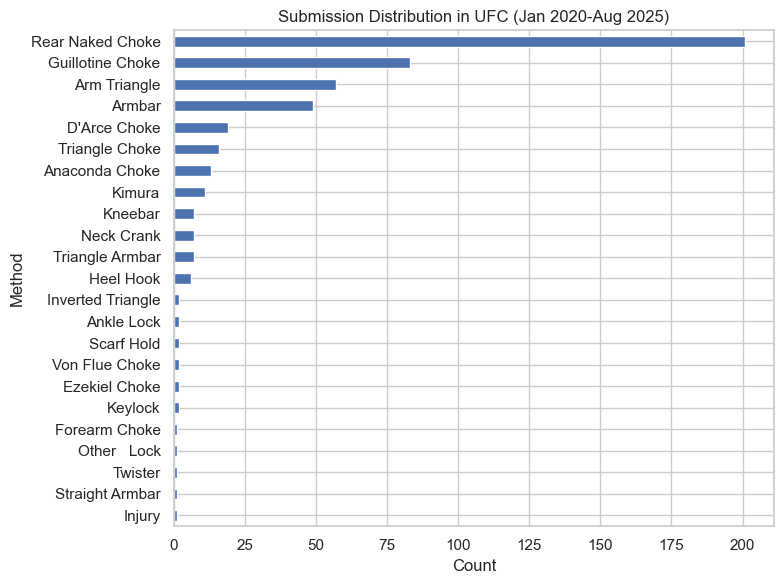

In [ ]:
plt.figure(figsize=(8, 6))
counts.sort_values().plot(kind="barh")
plt.title("Submission Distribution in UFC (Jan 2020-Aug 2025)")
plt.xlabel("Count")
plt.tight_layout()
plt.show()


**Takeaway:** A few submissions (e.g., RNC, Guillotine) account for a large share; grouping rare entries keeps the chart legible.


### Correlation Snapshot (Numeric Columns)

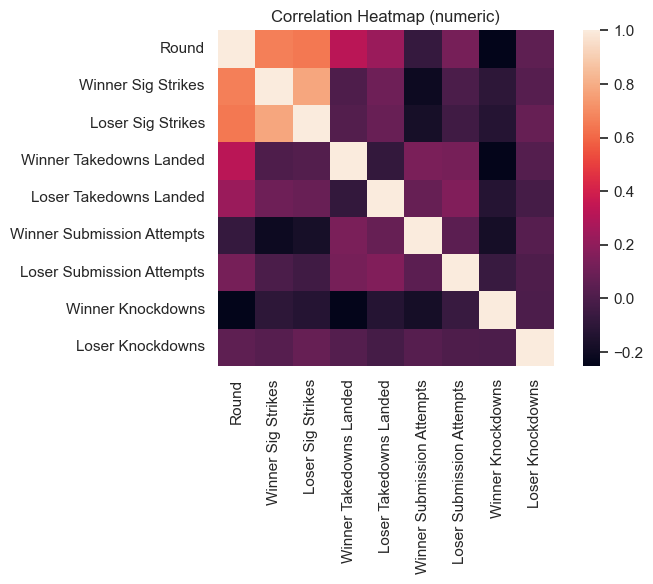

In [ ]:

num = event_df.select_dtypes(include="number")
corr = num.corr(numeric_only=True)

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=False, square=True, cbar=True)
plt.title("Correlation Heatmap (numeric)")
plt.tight_layout()
plt.show()
